# 模拟海洋感知

## 一.目标
* 输入船只数据
* 输出以单只船为核心的海洋感知图

## 二. 船只数据
2.1 船只数据的格式
* 数据库格式
    * 目标类型：船舶
    * 船名
    * 呼号
    * 长
    * 宽
    * 船舶类型
    * 船旗国
    * 船籍港
    * 船舶管理公司
    * 船舶建造厂
    * 船舶建造地点
    * 船舶建造时间
    * 下水时间
* 运行格式
    * 经度
    * 纬度
    * 航速
    * 航向
    * 出发地
    * 目的地

2.2 非船只数据格式
* 礁石
    * 目标类型：礁石
    * 长
    * 宽
    * 高
    
* 冰山或大型海洋生物或海洋垃圾
    * 目标类型：冰山或大型海洋生物或海洋垃圾
    * 长
    * 宽
    * 高
    * 经度
    * 纬度
    * 航速
    * 航向



## 三.假想可用态势格式
* 护航
    * 民事方面：护卫艇-护航-游轮，护卫艇-护航-货轮，护卫艇-护航-渔船
        * 中国海军护航编队，是中国海军海外护航的舰船编队，是从2008年底开始中国海军在亚丁湾索马里海盗频发海域护航的一项军事行动。
    * 军事方面：军舰-护航-主舰
* 追捕
    * 民事方面：执法艇-追捕-游艇，执法艇-追捕-偷渡艇，执法艇-追捕-非法入境艇
    * 军事方面：
* 避障
    * 船只-避障-礁石，船只-避障-冰山，船只-避障-大型海洋生物，船只-避障-海洋垃圾
* 未知


























In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import math
%matplotlib inline

# 中心船只的雷达半径，单位海里
radar_radius = 400

fontsize = 15
config_dict = {
    '中心船舶':{
        'num_range':(1,2),
        'speed_range':(0,100),
        'draw_dict':{
            'markersize':'20',
            'fmt':'r*'
        }
    },
    '感知船舶':{
        'num_range':(2,7),
        'speed_range':(0,100),
        'draw_dict':{
            'markersize':'12',
            'fmt':'b^'
        }
    },
    '冰山':{
        'num_range':(0,2),
        'speed_range':(0,5),
        'draw_dict':{
            'markersize':'12',
            'fmt':'ro'
        },
        'Length_range':(50,100),
        'Width_range':(50,100),
        'Draught_range':(3,10)
    },
    '礁石':{
        'num_range':(0,2),
        'speed_range':(0,1),
        'draw_dict':{
            'markersize':'12',
            'fmt':'ro'
        },
        'Length_range':(50,100),
        'Width_range':(50,100),
        'Draught_range':(3,10)
    },
    '生物':{
        'num_range':(0,2),
        'speed_range':(0,10),
        'draw_dict':{
            'markersize':'12',
            'fmt':'ro'
        },
        'Length_range':(50,100),
        'Width_range':(50,100),
        'Draught_range':(3,10)
    }
}

In [6]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
dfp_test = pd.read_csv('data/船讯网数据样本_长江口数据.csv')
dfp_test['ShipName'] = ['浙普渔运03',
 '浙普渔运03',
 '浙普渔运03',
 '浙普渔运03',
 '海巡01',
 '海巡01',
 '海巡01',
 '海巡01',
 '668588',
 '长安门号',
 '长安门号',
 '长安门号',
 '长安门号',
 '长安门号',
 '浙岭渔运08',
 '浙岭渔运08',
 '浙岭渔运08',
 '浙岭渔运08',
 '亨利04',
 '亨利04',
 '亨利04',
 '亨利04',
 '神华浚02',
 '神华浚02',
 '神华浚02',
 '神华浚02',
 '虎扑渔09',
 '虎扑渔09',
 '虎扑渔09',
 '虎扑渔09',
 '皇家创新号',
 '皇家创新号',
 '皇家创新号',
 '皇家创新号',
 '皇家创新号',
 '皇家创新号',
 '浙岱渔71',
 '浙岱渔71',
 '浙岱渔71',
 '浙岱渔71',
 '浙岱渔71',
 '浙岱渔71']
dfp_use_test = dfp_test[['ShipName','CallSign','ShipTypeCN','NavStatusCN','Length','Width','Draught']]\
    .rename(columns={'ShipTypeCN':'ShipType','NavStatusCN':'NavStatus'})\
    .drop_duplicates()\
    .dropna(subset = ['ShipType'])\
    .reset_index(drop=True)
dfp_use_test

,ShipName,CallSign,ShipType,NavStatus,Length,Width,Draught
0,浙普渔运03,YQ8YR7,捕捞,在航,27,6,NaN
1,海巡01,BSKY,执法艇,在航,44,8,2.8
2,长安门号,BFJJ,货船,在航,147,21,8.2
3,浙岭渔运08,NaN,捕捞,在航,35,6,NaN
4,亨利04,BKJJ,货船,在航,53,9,NaN
5,神华浚02,BDNI6,疏浚或水下作业,在航,135,27,7.1
6,虎扑渔09,NaN,捕捞,在航,31,6,NaN
7,皇家创新号,3FRF2,货船,在航,169,27,9.8
8,皇家创新号,3FRF2,货船,锚泊,169,27,9.8
9,浙岱渔71,5177,捕捞,在航,50,7,5.0


* entity_id:实体的唯一标识
* entity_type:实体类型（中心船舶，感知船舶，冰山，礁石，大型海洋生物）
* DrawX:以中心船舶为中心的x轴位移量,方向始终北方向=y轴正方向
* DrawY:以中心船舶为中心的y轴位移量,方向始终北方向=y轴正方向
* Course：航向,0——360,单位度,从北方向顺时针一圈开始计算，除礁石默认为-1之外所有实体均有值
* Speed：航速,0-100（一般为0～30）,单位节/小时,除礁石默认为-1之外所有实体均有值
* ShipName:船名，比如：东方号，长航凤凰号等,非船舶默认为'-1'
* CallSign:呼号,比如:YQ8YR7,BSKY等,非船舶默认为‘-1’
* ShipType:船舶类型，非船舶默认为'-1'
* NavStatus:船舶状态(在航，抛锚),非船舶默认为'-1'
* Length:长，单位米
* Width:宽，单位米
* Draught：吃水，单位米
* Lon:经度,-180～180,西经为负数,单位度
* Lat:纬度,-90～90,南纬为负数,单位度

In [7]:
# 通过米勒坐标系完成经纬度转换
class millerTransfer(object):
    @staticmethod
    def millerToXY (lon, lat):
        """
        经纬度(-180~180)转换为平面坐标系中的x,y 利用米勒坐标系
        :param lon: 经度
        :param lat: 维度
        :return:转换结果的单位是公里
        """
        L = 6381372*math.pi*2
        W = L
        H = L/2
        mill = 2.3
        x = lon*math.pi/180
        y = lat*math.pi/180
        y = 1.25*math.log(math.tan(0.25*math.pi+0.4*y))
        x = (W/2)+(W/(2*math.pi))*x
        y = (H/2)-(H/(2*mill))*y

        return x,y
    
    @staticmethod
    def millerToLonLat(x,y):
        """
        将平面坐标系中的x,y转换为经纬度，利用米勒坐标系
        :param x: x轴
        :param y: y轴
        :return:
        """
        L = 6381372 * math.pi*2
        W = L
        H = L/2
        mill = 2.3
        lat = ((H/2-y)*2*mill)/(1.25*H)
        lat = ((math.atan(math.exp(lat))-0.25*math.pi)*180)/(0.4*math.pi)
        lon = (x-W/2)*360/W

        return lon,lat

In [8]:
dfp_use = dfp_use_test

# 构建数据集
columns = ['entity_id','entity_type','DrawX','DrawY',
           'Length','Width','Draught','Course',
           'Speed','ShipName','CallSign','ShipType',
           'NavStatus','Lon','Lat','display_text']

dfp_list = []
for entity_type in config_dict.keys():
    min_num,max_num = config_dict[entity_type]['num_range']
    num = np.random.randint(low=min_num,high=max_num)
    print(f'生成{entity_type},数量:{num}')
    if num == 0:
        continue
    if entity_type in ['中心船舶','感知船舶']:
        dfp_sample = dfp_use.sample(n=num)
        # 不放回抽样
        dfp_use = dfp_use.iloc[list(set(range(len(dfp_use))) - set(dfp_sample.index)),:]
    else:
        # 非船舶实体，构造空列即可
        sample_data = {}
        for co in dfp_use.columns:
            if co in ['Length','Width','Draught']:
                min_num,max_num = config_dict[entity_type][f'{co}_range']
                sample_data[co] = np.random.rand(num)*(max_num-min_num) + min_num
            else:
                sample_data[co] = [-1]*num
        dfp_sample = pd.DataFrame(sample_data)
    # 上entity_type,DrawX,DrwaY,Speed,Courese
    dfp_sample['entity_type'] = entity_type
    if entity_type == '中心船舶':
        dfp_sample['DrawX'] = 0.0
        dfp_sample['DrawY'] = 0.0
        middle_lon = np.random.rand(num).item() * 360 - 180
        middle_lat = np.random.rand(num).item() * 180 - 90
        print(middle_lon,middle_lat)
        middle_x,middle_y = millerTransfer.millerToXY(middle_lon,middle_lat)
        dfp_sample['Lon'] = middle_lon
        dfp_sample['Lat'] = middle_lat
    else:
        r = np.random.rand(num)*radar_radius
        theta = np.random.rand(num)*360
        dfp_sample['DrawX'] = r*np.cos(theta)
        dfp_sample['DrawY'] = r*np.sin(theta)
        # 计算其他目标的经纬度的步骤1.得到转化前的x,y 2.转化为经纬度
        dfp_middle = dfp_sample.apply(lambda s:millerTransfer.millerToLonLat(middle_x+s['DrawX'],middle_y+s['DrawY']),axis=1)
        dfp_sample['Lon'] = dfp_middle.apply(lambda s:s[0])
        dfp_sample['Lat'] = dfp_middle.apply(lambda s:s[1])
        
        
    min_num,max_num = config_dict[entity_type][f'speed_range']    
    dfp_sample['Speed'] = np.random.rand(num)*(max_num-min_num) + min_num
    dfp_sample['Course'] = np.random.rand(num)*360
    dfp_list.append(dfp_sample)
    
dfp_data = pd.concat(dfp_list,axis=0).reset_index(drop=True)
dfp_data['entity_id'] = range(dfp_data.shape[0])
display_cols = ['ShipName','ShipType','NavStatus','Length','Width','Draught']
dfp_data['display_text'] = dfp_data.apply(
    lambda s:(f'船{s.entity_id}-' + '-'.join([str(s[co]) for co in display_cols])) if s.ShipName != -1 else f'{s.entity_type}{s.entity_id}',axis=1)
dfp_data = dfp_data[columns]

dfp_data

生成中心船舶,数量:1
129.9641911180663 -8.071862134097245
生成感知船舶,数量:3
生成冰山,数量:0
生成礁石,数量:1
生成生物,数量:1


,entity_id,entity_type,DrawX,DrawY,Length,Width,Draught,Course,Speed,ShipName,CallSign,ShipType,NavStatus,Lon,Lat,display_text
0,0,中心船舶,0.000000,0.000000,169.000000,27.000000,9.800000,173.761636,15.666683,皇家创新号,3FRF2,货船,在航,129.964191,-8.071862,船0-皇家创新号-货船-在航-169.0-27.0-9.8
1,1,感知船舶,-180.223464,158.853536,135.000000,27.000000,7.100000,255.266156,26.613831,神华浚02,BDNI6,疏浚或水下作业,在航,129.962573,-8.073937,船1-神华浚02-疏浚或水下作业-在航-135.0-27.0-7.1
2,2,感知船舶,-153.066743,73.395854,27.000000,6.000000,NaN,198.451096,49.667864,浙普渔运03,YQ8YR7,捕捞,在航,129.962817,-8.072821,船2-浙普渔运03-捕捞-在航-27.0-6.0-nan
3,3,感知船舶,140.923529,213.712081,169.000000,27.000000,9.800000,123.997059,83.637098,皇家创新号,3FRF2,货船,锚泊,129.965456,-8.074654,船3-皇家创新号-货船-锚泊-169.0-27.0-9.8
4,4,礁石,4.494155,-231.278026,54.926815,66.766429,9.514995,220.771715,0.810286,-1,-1,-1,-1,129.964231,-8.068841,礁石4
5,5,生物,-254.195706,-263.592660,86.685158,92.176798,9.154024,54.540350,1.256270,-1,-1,-1,-1,129.961909,-8.068419,生物5


# 构造不带关系的图形

Text(0.5, 1.0, 'label:id-ShipName-ShipType-NavStatus-Length-Width-Draught')

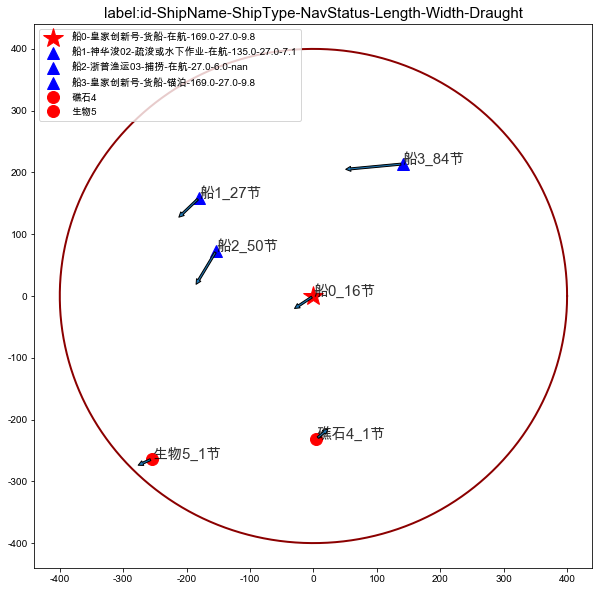

In [13]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# 先画雷达导航区域
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta) * radar_radius
y = np.sin(theta) * radar_radius
fig = plt.figure(figsize=(10, 10))
# ax1 = plt.subplot(2,2,1)
plt.plot(x, y, color="darkred", linewidth=2)

#生成感知目标
for index,row in dfp_data.iterrows():
    fmt = config_dict[row.entity_type]['draw_dict']['fmt']
    markersize = config_dict[row.entity_type]['draw_dict']['markersize']
    plt.plot(row.DrawX,row.DrawY,fmt,markersize=markersize,label=row.display_text)
    plt.text(row.DrawX,row.DrawY,row.display_text.split('-')[0]+'_'+f'{round(row.Speed)}节' ,fontsize = fontsize,alpha=0.8) 
    speed_current_long = radar_radius/15 + radar_radius/5 * row.Speed / 100  
    des_xy = (row.DrawX+np.sin(row.Course)*speed_current_long,row.DrawY+np.cos(row.Course)*speed_current_long)
#     des_xy = (row.DrawX+np.sin(row.Course)*radar_radius/8,row.DrawY+np.cos(row.Course)*radar_radius/8)
    plt.annotate('',
                 xy=des_xy,
                 xytext=(row.DrawX,row.DrawY),
                 arrowprops=dict(arrowstyle="simple",connectionstyle="arc3")
                )

# 生成态势感知，即关系




plt.legend(loc=2)
plt.title('label:id-'+'-'.join(display_cols),fontsize=fontsize)

In [ ]:
isinstance

# 构造带关系的图形


* Dataframe格式，src_id,relation_type,des_id
* 护航
    * 民事方面：护卫艇-护航-游轮，护卫艇-护航-货轮，护卫艇-护航-渔船
        * 中国海军护航编队，是中国海军海外护航的舰船编队，是从2008年底开始中国海军在亚丁湾索马里海盗频发海域护航的一项军事行动。
    * 军事方面：军舰-护航-主舰
* 追捕
    * 民事方面：执法艇-追捕-游艇，执法艇-追捕-偷渡艇，执法艇-追捕-非法入境艇
    * 军事方面：
* 避障
    * 船只-避障-礁石，船只-避障-冰山，船只-避障-大型海洋生物，船只-避障-海洋垃圾
* 未知




In [313]:
def simulate_relation(s):
    if s.src_entity_id == s.des_entity_id:
        return '未知'
    
    if '船舶' in s.des_entity_type:
        r_num = np.random.rand(1).item()
        for re,value in ship2ship.items():
            if r_num < value:
                return re
    else:
        # 船舶与非船舶的关系
        distance = math.sqrt((s.src_DrawX-s.des_DrawX)**2+
                          (s.src_DrawY-s.des_DrawY)**2)
        if distance < radar_radius*ship2noship:
            return '避障'
        else:
            return '未知'



dfp_data_ship = dfp_data[dfp_data.entity_type.str.contains('船舶')][['entity_id','entity_type','DrawX','DrawY']]
dfp_data_ship_src = dfp_data_ship.rename(columns=dict([(co,f'src_{co}') for co in dfp_data_ship.columns]))
dfp_data_des = dfp_data[['entity_id','entity_type','DrawX','DrawY']]
dfp_data_des = dfp_data_des.rename(columns=dict([(co,f'des_{co}') for co in dfp_data_ship.columns]))


dfp_list = []
for i,row_src in dfp_data_ship_src.iterrows():
    for j,row_des in dfp_data_des.iterrows():
        dfp_list.append(row_src.append(row_des))
dfp_edge = pd.concat(dfp_list,axis=1).T
dfp_edge['relation_type'] = dfp_edge.apply(simulate_relation,axis=1)
dfp_edge = dfp_edge[dfp_edge.relation_type != '未知'][edge_columns]
dfp_edge

,src_entity_id,relation_type,des_entity_id,src_DrawX,src_DrawY,des_DrawX,des_DrawY
10,1,追捕,4,349.889,-148.153,242.112,-17.229
12,1,追捕,6,349.889,-148.153,-50.7921,-111.737
14,2,追捕,0,326.009,-53.9386,0,0
16,2,追捕,3,326.009,-53.9386,11.0296,-25.7969
17,2,追捕,4,326.009,-53.9386,242.112,-17.229
18,2,护航,5,326.009,-53.9386,294.352,-259.06
21,3,护航,0,11.0296,-25.7969,0,0
22,3,追捕,1,11.0296,-25.7969,349.889,-148.153
23,3,护航,2,11.0296,-25.7969,326.009,-53.9386
25,3,追捕,5,11.0296,-25.7969,294.352,-259.06


Text(0.5, 1.0, 'label:id-ShipName-ShipType-NavStatus-Length-Width-Draught')

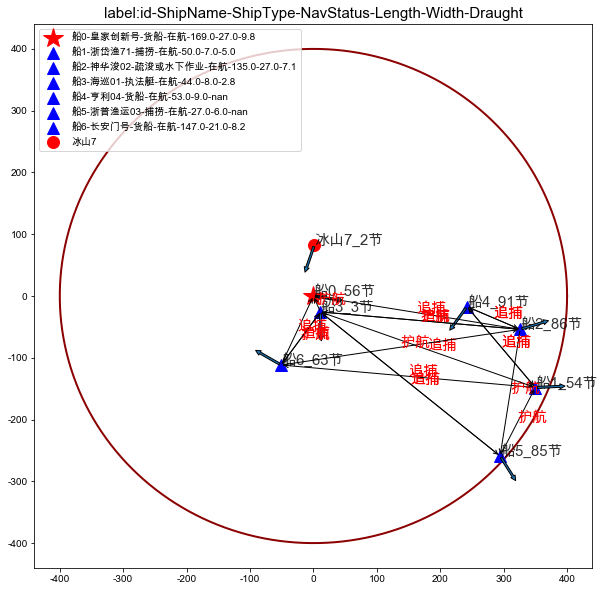

In [320]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


# 先画雷达导航区域
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta) * radar_radius
y = np.sin(theta) * radar_radius
fig = plt.figure(figsize=(10, 10))
# ax1 = plt.subplot(2,2,1)
plt.plot(x, y, color="darkred", linewidth=2)

#生成感知目标
for index,row in dfp_data.iterrows():
    fmt = config_dict[row.entity_type]['draw_dict']['fmt']
    markersize = config_dict[row.entity_type]['draw_dict']['markersize']
    plt.plot(row.DrawX,row.DrawY,fmt,markersize=markersize,label=row.display_text)
    plt.text(row.DrawX,row.DrawY,row.display_text.split('-')[0]+'_'+f'{round(row.Speed)}节' ,fontsize = fontsize,alpha=0.8)  
    des_xy = (row.DrawX+np.sin(row.Course)*radar_radius/8,row.DrawY+np.cos(row.Course)*radar_radius/8)
    plt.annotate('',
                 xy=des_xy,
                 xytext=(row.DrawX,row.DrawY),
                 arrowprops=dict(arrowstyle="simple",connectionstyle="arc3")
                )

# 生成态势感知，即关系
for index,row in dfp_edge.iterrows():
    des_xy = (row.des_DrawX,row.des_DrawY)
    src_xy = (row.src_DrawX,row.src_DrawY)
    plt.annotate('',
                 xy=des_xy,
                 xytext=src_xy,
                 arrowprops=dict(arrowstyle="->",
                                 connectionstyle="arc3",
                                 facecolor=plt_relation_color_dict[row.relation_type]),
                 alpha=0.5
    )
    text_x = (row.des_DrawX + row.src_DrawX)/2
    text_y = (row.des_DrawY + row.src_DrawY)/2
    plt.text(text_x,text_y,row.relation_type,fontsize=fontsize,color='r')
    
plt.legend(loc=2)
plt.title('label:id-'+'-'.join(display_cols),fontsize=fontsize)

In [321]:
import os

In [324]:
max([int(i) for i in os.listdir('pic/v0') if i.isalnum()])

4

In [325]:
max([])

ValueError: max() arg is an empty sequence

In [329]:
relation_type_dict = {
    0:'追捕',
    1:'护航',
    2:'避障'
}
edge_str = '001,012,023'
edge_list = [[int(l[0]),relation_type_dict[int(l[1])],int(l[2])] for l in edge_str.split(',')]

In [328]:
for l in edge_str.split(','):
    print(l[0])

0
0
0
